In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math

In [2]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")

In [177]:
precip_scaler = StandardScaler()
gdp_scaler = StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data_no_missing.UDel_precip_popweight).reshape(-1,1))
gdp_scaled = gdp_scaler.fit_transform(np.array(data_no_missing.growthWDI).reshape(-1,1))

In [169]:
with pm.Model() as model:
    
    # temp_prior = pm.Normal("temp_prior", np.mean(data_no_missing.UDel_temp_popweight), np.std(data_no_missing.UDel_temp_popweight))
    # temp_std = pm.HalfNormal("temp_std", 10)
    # temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=data_no_missing.UDel_temp_popweight)

    # precip_prior = pm.Normal("precip_prior", np.mean(data_no_missing.UDel_precip_popweight), np.std(data_no_missing.UDel_precip_popweight))
    precip_prior = pm.Normal("precip_prior", 0, 1)
    precip_std = pm.HalfNormal("precip_std", 10)
    # precip_posterior = pm.Normal("precip_posterior", precip_prior, precip_std, observed=data_no_missing.UDel_precip_popweight)
    precip_posterior = pm.Normal("precip_posterior", precip_prior, precip_std, observed=precip_scaled)

    gdp_intercept = pm.Normal('gdp_intercept',0,10)
    # temp_gdp_coef = pm.Normal('temp_gdp_coef',0,10)
    # temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,10)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,10)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,10)

    gdp_prior = pm.Deterministic(
        "gdp_prior",
        gdp_intercept +
        # (temp_posterior * temp_gdp_coef) +
        # (pt.sqr(temp_posterior) * temp_sq_gdp_coef) +
        (precip_posterior * precip_gdp_coef) +
        (precip_sq_gdp_coef * pt.sqr(precip_posterior))
    )

    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    # gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=data_no_missing.growthWDI)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)

    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

# with open ('../models/burke-reproduction-no-effects-missing-rows-omitted.pkl', 'wb') as buff:
#     pkl.dump({
#         "prior":prior,
#         "trace":trace,
#         "posterior":posterior
#     },buff)

Sampling: [gdp_intercept, gdp_posterior, gdp_std, precip_gdp_coef, precip_posterior, precip_prior, precip_sq_gdp_coef, precip_std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [precip_prior, precip_std, gdp_intercept, precip_gdp_coef, precip_sq_gdp_coef, gdp_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [gdp_posterior, precip_posterior]


/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_9082/1678283998.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


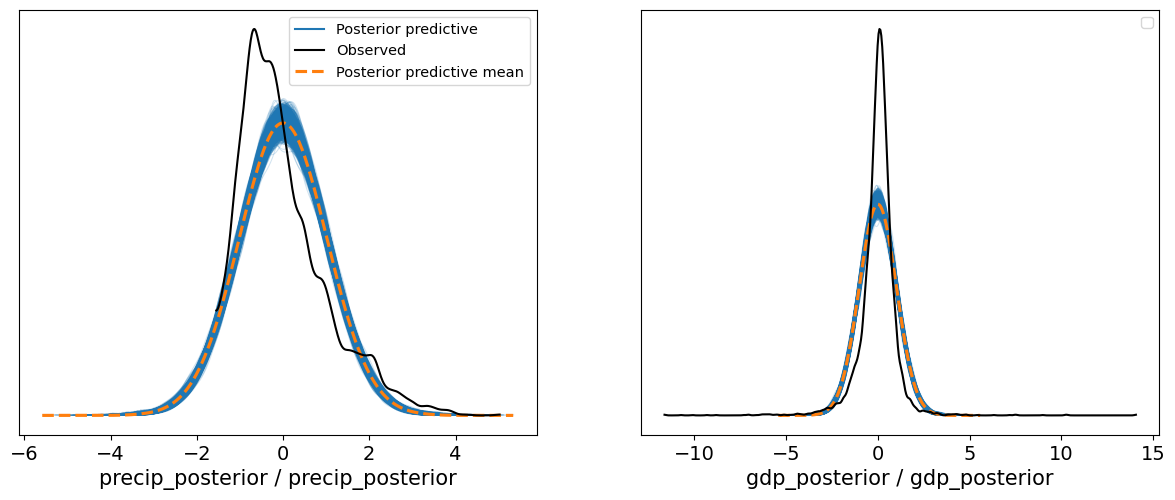

In [170]:
fig = az.plot_ppc(posterior).ravel()[0].figure
fig.show()

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_9082/3624891223.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


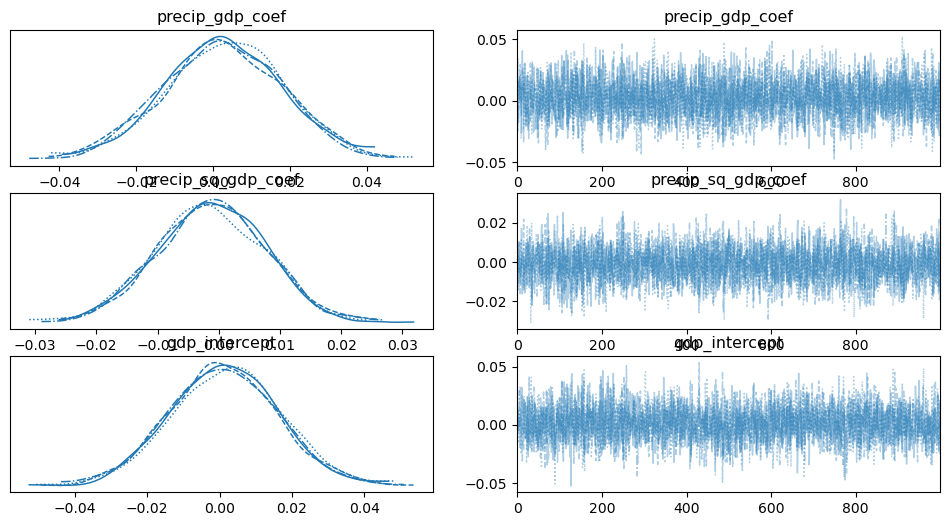

In [171]:
fig = az.plot_trace(trace, var_names=["precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"]).ravel()[0].figure
fig.show()

In [3]:
trace = pd.read_pickle('../models/burke-reproduction-no-effects.pkl')["trace"]

In [175]:
# print(np.mean(trace.posterior.temp_gdp_coef.data))
# print(np.mean(trace.posterior.temp_sq_gdp_coef.data))
print(np.mean(trace.posterior.precip_gdp_coef.data))
print(np.mean(trace.posterior.precip_sq_gdp_coef.data))
print(np.mean(trace.posterior.gdp_intercept.data))

0.002782225040315808
-0.0012057357445743487
0.001359713211961127


In [197]:
from sklearn.linear_model import LinearRegression
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
X = np.column_stack((
    # data_no_missing.UDel_temp_popweight,
    # np.square(data_no_missing.UDel_temp_popweight),
    data_no_missing.UDel_precip_popweight,
    np.square(data_no_missing.UDel_precip_popweight)
))
# X = np.array(data_no_missing.UDel_precip_popweight).reshape(-1,1)
Y = np.array(data_no_missing.growthWDI).reshape(-1,1)
linreg = LinearRegression().fit(X,Y)
print(linreg.coef_)
print(linreg.intercept_)

[[ 5.09188087e-07 -1.26889030e-10]]
[0.01772894]


In [196]:
precip_data = precip_scaler.inverse_transform(np.array(posterior.posterior_predictive.precip_posterior.data.flatten()).reshape(-1,1))
gdp_data = gdp_scaler.inverse_transform(np.array(posterior.posterior_predictive.gdp_posterior.data.flatten()).reshape(-1,1))
X = np.column_stack((
    precip_data,
    np.square(precip_data)
))
linreg = LinearRegression().fit(X,gdp_data)
print(linreg.coef_)
print(linreg.intercept_)

[[ 5.83812301e-07 -1.56442079e-10]]
[0.017692]
